<a href="https://colab.research.google.com/github/hye0-n0/hye0-n0/blob/main/IE437_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Load library
#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

## Step1: Data Preparation
### Get Offline data from csv file and Split into train and validation set
This data consists of pairs of decision variables and their corresponding exam scores


### Get Offline data from csv file
Decision variables
* A: Reading a Book
* B: Solving Examples
* C: Taking a Rest
* D: Discussing with Friends
* E: Getting Sleep


In [32]:
# Load the offline dataset containing pairs of decision variables and exam scores
data = pd.read_csv('/content/log.csv')
data.describe()

,A,B,C,D,E,score
count,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000
mean,0.498985,0.498149,0.494426,0.495300,0.498725,71.645244
std,0.291844,0.289512,0.289011,0.289082,0.289978,4.333470
min,0.000064,0.000010,0.000397,0.000126,0.000233,62.944380
25%,0.244372,0.247665,0.241093,0.242532,0.245855,68.460217
50%,0.499789,0.498503,0.491682,0.494536,0.497319,70.780107
75%,0.754511,0.749839,0.747202,0.743745,0.750852,74.079871
max,0.999860,0.999969,0.999882,0.999996,0.999987,89.830920


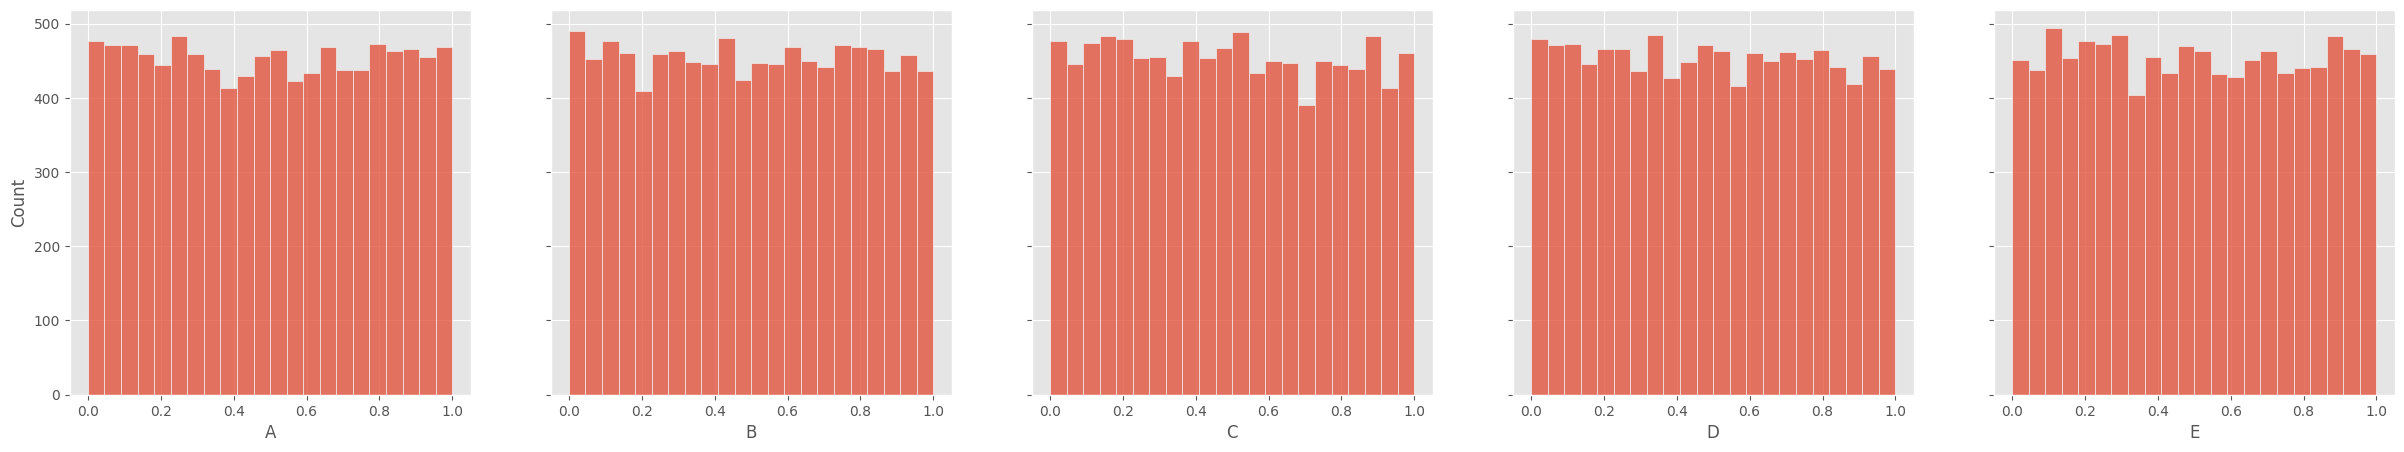

In [33]:
# Visualize Data Distribution
plt.style.use("ggplot")
fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
for i in range(5):
    sns.histplot(data.iloc[:, i], ax=axes[i])
plt.show()

<Figure size 768x576 with 0 Axes>

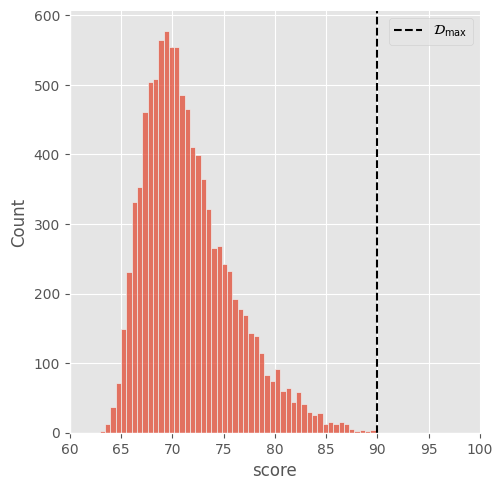

In [34]:
# Visualize Data Distribution
plt.style.use("ggplot")
plt.figure(dpi=120)
sns.displot(data['score'])
plt.xlim(60, 100)
plt.axvline(90, linestyle="--", color="black", label="$\mathcal{D}_{\max}$")
plt.legend()

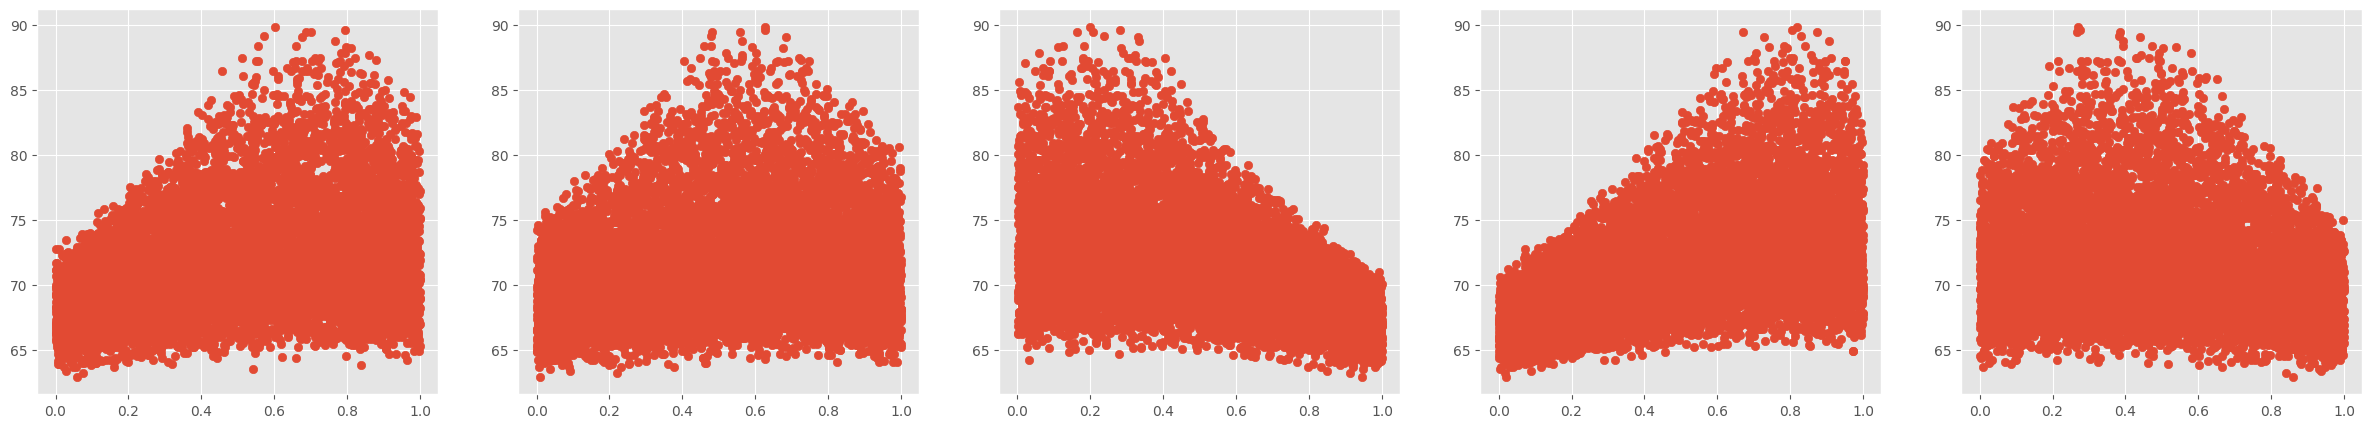

In [35]:
# Visualize Data Distribution
plt.style.use("ggplot")
plt.figure(figsize=(30, 5))
for i in range(data.shape[1]-1):
    plt.subplot(1, 5, i+1)
    plt.scatter(data.iloc[:, i], data["score"])

#### Visualize Data Distribution
1. all of A, B, C, D, E are similar distribution
2. skewness of score is positive
3. "A", "D" seems like weak positive correlation of score
  
  "B" seems like weak negative correlation of score

In [36]:
data[data["score"] == max(data["score"])]

,A,B,C,D,E,score
8446,0.602218,0.626019,0.199243,0.81822,0.270729,89.83092


#### Maximum score in the data
The person who scored the highest spent more time reading a book (A), solving examples (B), and discussing with friends (D) than taking a rest (C) and getting sleep (E)



### Split into Train and Validation set

In [37]:
# Split into Train and Validation set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = torch.from_numpy(data.values).float().to(device)
x, y = df[:, :5], df[:, -1:]

num_points = x.shape[0]
train_x, valid_x = x[:int(num_points * 0.8)], x[int(num_points * 0.8):]
train_y, valid_y = y[:int(num_points * 0.8)], y[int(num_points * 0.8):]

## Step2: Model Training
### Choose model and Train the model using the training data

### Simple DNN using 3 hidden layers

Ultimately, I configured a simple DNN by experimenting with different hyperparameter values.

I varied the hidden dimension {16, 32, 64, 128, 256} for each layer and batch size {128, 256, 512}, adjusted the number of layers {2, 3, 4}, and added dropout to prevent overfitting.

In [38]:
class BaseMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout):
        super(BaseMLP, self).__init__()

        self.model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                   nn.ReLU(),
                                   nn.Dropout(dropout),
                                   nn.Linear(hidden_dim, int(hidden_dim/2)),
                                   nn.ReLU(),
                                   nn.Dropout(dropout),
                                   nn.Linear(int(hidden_dim/2), int(hidden_dim/4)),
                                   nn.ReLU(),
                                   nn.Linear(int(hidden_dim/4), int(hidden_dim/4)),
                                   nn.ReLU(),
                                   nn.Linear(int(hidden_dim/4), output_dim))

    def forward(self, x):
        return self.model(x)

In [39]:
# Hyperparameters for training neural network
batch_size = 256
training_step = 10000
validation_interval = 1000
lr = 1e-3

In [40]:
# Define optimizer and loss function
model = BaseMLP(input_dim=5, output_dim=1, hidden_dim=128, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

### Training the model and Set the objective function

In [41]:
# Train a neural network
model = model.to(device)

train_losses = []
valid_losses = []
for step in range(training_step):
    idx = torch.randint(0, len(train_x), size=(batch_size, ))

    batch_train_x, batch_train_y = train_x[idx], train_y[idx]
    batch_pred_y = model(batch_train_x)

    optimizer.zero_grad()

    train_loss = criterion(batch_train_y, batch_pred_y)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    if (step+1) % validation_interval == 0:
        valid_loss = criterion(model(valid_x), valid_y)
        valid_losses.append(valid_loss.item())

        print(f"Step: {step+1}/{training_step}\tTrain Loss: {train_losses[-1]:.2f}\tValid Loss: {valid_losses[-1]:.2f}")

Step: 1000/10000	Train Loss: 42.84	Valid Loss: 42.16
Step: 2000/10000	Train Loss: 22.96	Valid Loss: 22.38
Step: 3000/10000	Train Loss: 6.73	Valid Loss: 5.99
Step: 4000/10000	Train Loss: 3.26	Valid Loss: 3.46
Step: 5000/10000	Train Loss: 2.20	Valid Loss: 2.36
Step: 6000/10000	Train Loss: 1.73	Valid Loss: 1.88
Step: 7000/10000	Train Loss: 1.80	Valid Loss: 1.72
Step: 8000/10000	Train Loss: 1.48	Valid Loss: 1.21
Step: 9000/10000	Train Loss: 1.27	Valid Loss: 1.22
Step: 10000/10000	Train Loss: 1.23	Valid Loss: 1.14


In [42]:
# Objective function to maximize the output of DNN
def bo_objective(A, B, C, D, E):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = torch.float32  # setting the data type

    # Convert input x to tensor and add batch dimension
    x = torch.tensor([A, B, C, D, E], device=device, dtype=dtype).unsqueeze(0)

    return model(x).item()   # score: model(x)

## Step3: Optimization Algorithm

$ x^* = argmax_x f(x)$

subject to $0 \leq x \leq 1$

* $f(x)$: black-box function


### Bayesian Optimization
$ P(Model|data) \propto P(data|Model)*P(Model)\\
\Leftrightarrow Posterior \propto Likelihood * Prior$

------------------------------------

### Surrogate model

> Probabilistic model to estimate the distribution on unknown target values f = f(x) corresponding x



#### 1. Data

$ x \rightarrow f(x) \rightarrow y $

* $x_1, ..., x_n$

* $ y_i = f_i(x) + \epsilon_i, i=(1, ..., n)$



#### 2. Prior of the function values


$ \begin{bmatrix} f_1 \\ \vdots \\ f_n \end{bmatrix} \sim GP\left( \begin{bmatrix} m(x_1) \\ \vdots \\ m(x_n) \end{bmatrix}, \begin{bmatrix} k(x_1, x_1) & \cdots & k(x_1, x_n) \\ \vdots & \ddots & \vdots \\ k(x_n, x_1) & \cdots & k(x_n, x_n) \end{bmatrix} \right) $

* $m(x) = 0$
* $k(x, x') = \gamma\exp(-\cfrac{1}{2}(x-x')^T diag(\lambda)^-2(x-x'))$



#### 3. Likelihood based on Gaussian noise
$ (y_1, ..., y_n)|(f_1, ..., f_n) \sim N((f_1, ..., f_n)^T, \sigma^2_\epsilon I) $

* To find parameter, we maximize the log-likelihood of the training data $D={(x_i, y_i)}$



#### 4. Joint distribution based on Bayes' rule
$ \begin {bmatrix} (y_1, .., y_n) \\ f \end{bmatrix}  \sim GP(0, \begin {bmatrix}K+\sigma^2_\epsilon I & k \\ k^T & k(x, x)\end{bmatrix} )$



#### 5. Conditionalization: Posterior distribution $f$ given data

$f|D \sim N(\mu(x|D), \sigma^2(x|D))$

* $\mu(x|D) = k^T(K+\sigma^2_\epsilon I)^{-1} y_{1:n}$
* $\sigma^2(x|D) = k(x, x)-k^T(K+\sigma^2_\epsilon I)^{-1}k$

------------------------------------

### Acquisitic function
> Function that suggests candidates to look into to find the optimal value based on predicted mean and variance

$x^{(n+1)} = argmax_x EI(x)$

* Exploration : uncertainty is great
* Exploitation : prediction is high



### 1. UCB (Upper Confidence Bound)
`next input is maximum of Upper bound on uncertainty resulting from GP regression`

$ UCB(X) = \mu(x) + \kappa\sigma(x) $   

    
 ------------------------------------   
### 2. PI (Probability Improvement)
`probability of improving our current best estimate`

$PI(x) = p(f(x) \geq f(x^+)) = \Phi(\cfrac{\mu(x;\theta, D) - f(x^+) - \xi}{\sigma(x;\theta, D)})$
* $f_{max}(x) = f(x^+)$
* $\xi$ : trade off between Exploration and Exploitation
    
  $\xi \uparrow, Exploration \uparrow$: new input point move to great uncetainty

------------------------------------   
### 3. EI (Expected Improvement)
`how much better improving our current best estimate`
    
$EI(x) = (\mu(x) - f(x^+) - \xi)\Phi(Z)+\sigma(x)\phi(Z)$

* Z =  $\cfrac{\mu(x;\theta, D) - f(x^+) - \xi}{\sigma(x;\theta, D)} * I(\sigma(x>0))$

---------------


### My Bayesian Optimization
* surrogate model

  In bayesian-optimization package, Surrogate model is fixed to Gaussian Process

* acquisitic function

  I choose Expected Improvemnt
  


#### bayesian-optimization package
1. BayesianOptimization
* f : function to be optimized (simple DNN)
* pbounds : parameters with their corresponding bounds (range of X)
2. optimizer.maximize
* init_points : # of steps of random exploration
* n_iter : # of steps of bayesian optimization
* acq : acquisition function
* xi : controls the relative intensity between exploration and exploration

In [44]:
# Find queries that maximizes the trained neural network
candidates = []
num_trials = 10 # SHOULD BE FIXED

# Search space for each input dimension
pbounds={'A': (0, 1), 'B': (0, 1), 'C': (0, 1), 'D': (0, 1), 'E': (0, 1)}

for trial in range(num_trials):

  # Initialize Bayesian Optimization
  optimizer = BayesianOptimization(
          f=bo_objective,  # bo_objective is black-box function (trained DNN)
          pbounds=pbounds)

  # Find queries that maximizes the trained simple DNN
  acq = UtilityFunction(kind="ei", xi=0.01)
  optimizer.maximize(init_points=5, n_iter=100, acquisition_function=acq)

  candidates.append(optimizer.max['params'])

|   iter    |  target   |     A     |     B     |     C     |     D     |     E     |
-------------------------------------------------------------------------------------
| 1         | 69.33     | 0.4818    | 0.4827    | 0.9712    | 0.9138    | 0.1116    |
| 2         | 70.85     | 0.07939   | 0.5228    | 0.2476    | 0.3053    | 0.3911    |
| 3         | 76.07     | 0.7922    | 0.8767    | 0.1251    | 0.4366    | 0.1291    |
| 4         | 70.01     | 0.4881    | 0.3713    | 0.921     | 0.9363    | 0.7127    |
| 5         | 70.12     | 0.4346    | 0.7323    | 0.7715    | 0.329     | 0.5585    |
| 6         | 72.97     | 0.879     | 0.9329    | 0.008281  | 0.4228    | 0.07284   |
| 7         | 71.1      | 0.3991    | 0.6792    | 0.1382    | 0.09532   | 0.4914    |
| 8         | 76.35     | 0.7881    | 0.8677    | 0.1705    | 0.471     | 0.1219    |
| 9         | 75.46     | 0.7801    | 0.9364    | 0.2043    | 0.4719    | 0.1431    |
| 10        | 78.49     | 0.739     | 0.7578    | 0.17

## Step 4: Reporting Results

In [46]:
# Save data into query.csv file
df = pd.DataFrame(candidates, columns=["A", "B", "C", "D", "E"])
df.to_csv("/content/query.csv", index=False)
df.head()

,A,B,C,D,E
0,0.740807,0.619585,0.241691,0.601016,0.348864
1,0.791495,0.555704,0.132013,0.850394,0.543378
2,0.776625,0.729726,0.088565,0.778261,0.487510
3,0.581368,0.606930,0.186078,0.752470,0.373789
4,0.874240,0.693442,0.097804,0.894010,0.347384


In [47]:
df.describe()

,A,B,C,D,E
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.713391,0.641421,0.175428,0.826233,0.417255
std,0.136490,0.074780,0.080804,0.108201,0.094019
min,0.440665,0.500465,0.053039,0.601016,0.294742
25%,0.632690,0.608717,0.106356,0.784075,0.347754
50%,0.758716,0.651032,0.176778,0.826086,0.386314
75%,0.787922,0.695415,0.247472,0.885835,0.491471
max,0.874240,0.729726,0.288318,1.000000,0.554257


### Result
On average, individuals who invest more time in reading a book, solving examples, and discussing with friends than in taking a rest and getting sleep tend to have higher scores.


Therefore, To get the highest score,
you need to invest a lot of time in study-related activities, and you need adequate rest and sleep.

In [60]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!jupyter nbconvert --to PDF '/content/drive/My Drive/ipynbToPDF.ipynb'